In [1]:
!pip install tf-nightly

In [2]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam, Adamax

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


         date     pred1        pred1r  ...    pred3r  result01  result02
0    20181010  0.999448  2.176207e-09  ...  0.999999  0.024389         1
1    20181011  0.999348  6.005895e-08  ...  0.999999  0.025967         1
2    20181012  0.999272  3.092785e-08  ...  0.999999  0.027723         1
3    20181015  0.999103  1.719783e-08  ...  0.999999  0.027981         1
4    20181016  0.998878  1.079646e-08  ...  0.999999  0.028750         1
..        ...       ...           ...  ...       ...       ...       ...
275  20191113  0.177229  2.477885e-05  ...  1.000000  0.011964        -1
276  20191114  0.151480  7.936539e-05  ...  1.000000  0.013425        -1
277  20191115  0.128467  2.030432e-04  ...  1.000000  0.015103        -1
278  20191118  0.110407  4.058480e-04  ...  1.000000  0.017198        -1
279  20191119  0.100982  6.110966e-04  ...  1.000000  0.018577        -1

[280 rows x 9 columns]


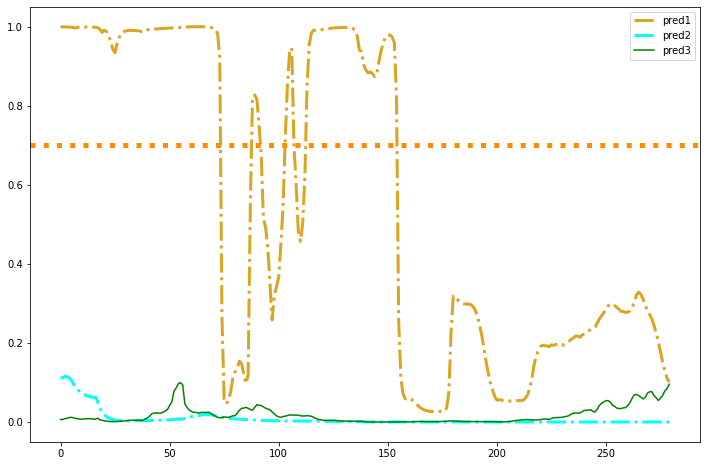

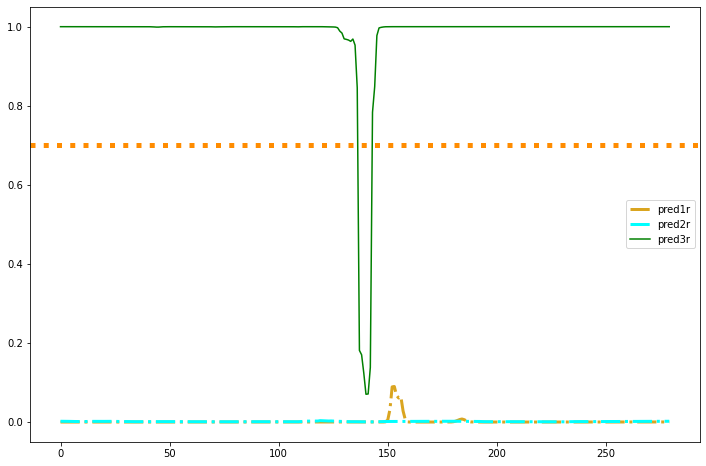

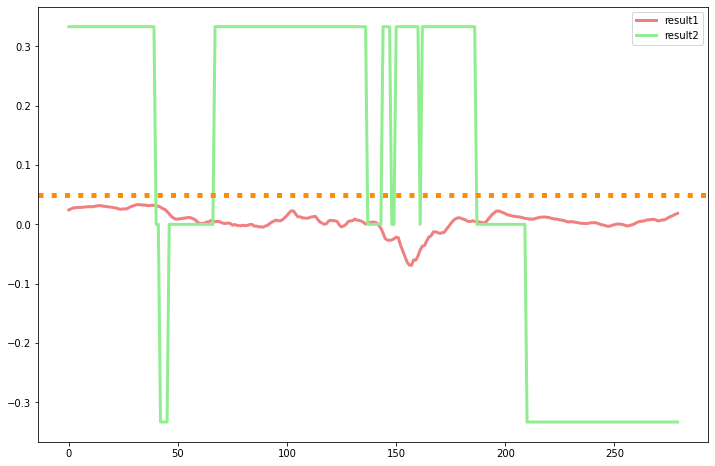

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df[-300:]

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']


df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if  row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:300]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[15:]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)
df2['result01'] = pd.Series(target)
df2['result02'] = pd.Series(target2)

df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/SBUX_dataset00.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/SBUX_dataset00.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result01'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)

plt.legend()
plt.show()

        date     pred1        pred1r     pred2    pred2r     pred3    pred3r
0   20200612  0.986662  2.085240e-08  0.001313  0.005632  0.000107  1.000000
1   20200615  0.984407  1.682272e-08  0.001458  0.023875  0.000204  1.000000
2   20200616  0.983083  4.341529e-09  0.001667  0.023377  0.000320  1.000000
3   20200617  0.982805  1.465742e-09  0.001689  0.022830  0.000359  1.000000
4   20200618  0.982752  6.253635e-10  0.001836  0.024115  0.000420  1.000000
..       ...       ...           ...       ...       ...       ...       ...
95  20201027  0.420411  1.731962e-16  0.000069  0.000410  0.010286  0.732806
96  20201028  0.397483  6.001413e-17  0.000067  0.000348  0.009278  0.543405
97  20201029  0.391940  1.130276e-17  0.000072  0.000337  0.009392  0.934784
98  20201030  0.386524  4.405019e-18  0.000075  0.000300  0.009504  0.995827
99  20201102  0.377772  1.355015e-18  0.000080  0.000277  0.012119  0.999571

[100 rows x 7 columns]


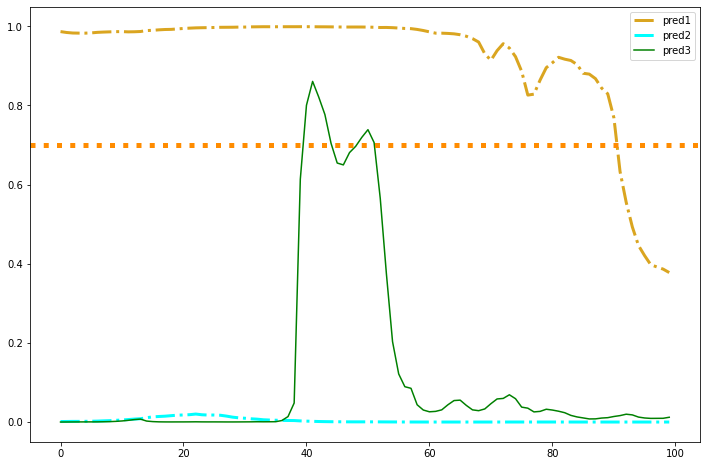

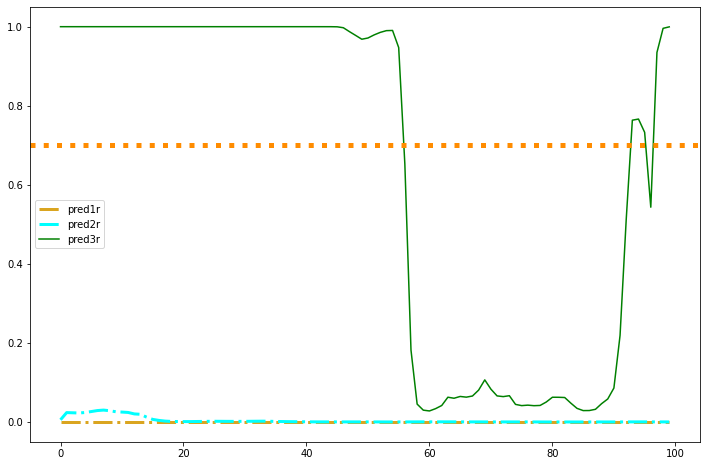

In [4]:
# 결과값이 없는 미래 예측을 위한 데이터셋 만들기
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df = df.dropna(axis=0)
df = df[-120:]

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:120]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[:-10]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[:-15]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)


df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/SBUX_dataset01.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/SBUX_dataset01.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

         date     pred1        pred1r  ...    pred3r  result01  result02
0    20181015  0.154712  4.422296e-13  ...  1.000000  0.007569        -1
1    20181016  0.165852  3.356953e-13  ...  1.000000  0.006947        -1
2    20181017  0.170183  3.118229e-13  ...  0.999999  0.005402        -1
3    20181018  0.303366  1.978981e-13  ...  0.999999  0.006859        -1
4    20181019  0.713905  1.792326e-13  ...  0.999999  0.008450        -1
..        ...       ...           ...  ...       ...       ...       ...
275  20191118  0.985678  3.477075e-18  ...  0.073518 -0.005269         1
276  20191119  0.986182  3.065162e-18  ...  0.072115 -0.005429         1
277  20191120  0.986393  2.606395e-18  ...  0.070119 -0.004244         1
278  20191121  0.986044  1.795363e-18  ...  0.061509 -0.003513         1
279  20191122  0.985866  1.108448e-18  ...  0.054910 -0.003735         1

[280 rows x 9 columns]


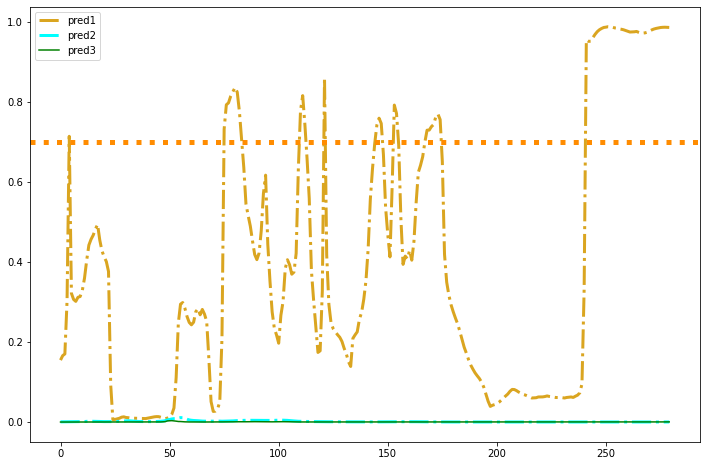

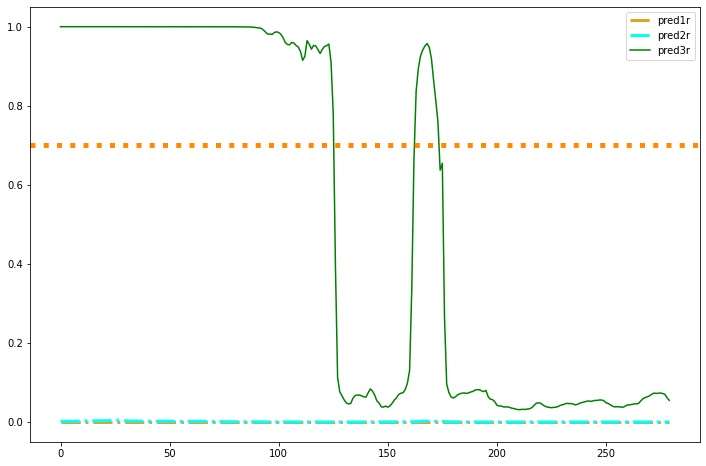

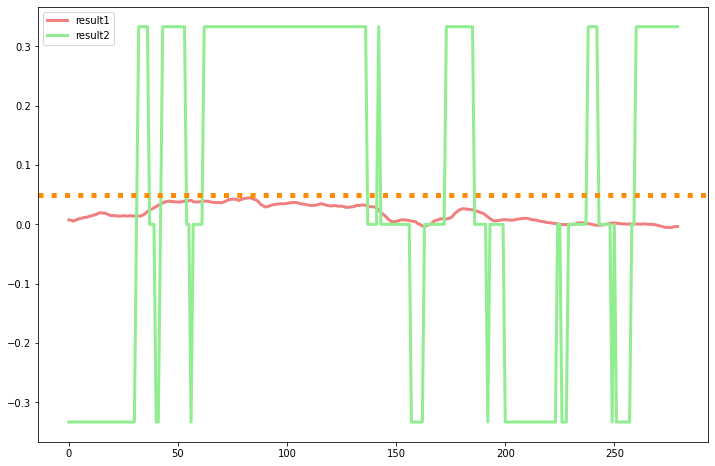

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df[-300:]

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if  row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:300]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[15:]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)
df2['result01'] = pd.Series(target)
df2['result02'] = pd.Series(target2)

df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/AMZN_dataset00.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/AMZN_dataset00.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result01'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)

plt.legend()
plt.show()

        date     pred1        pred1r     pred2    pred2r     pred3    pred3r
0   20200617  0.840925  5.115952e-13  0.027937  0.001771  0.001767  0.999941
1   20200618  0.817994  2.859320e-13  0.024570  0.001738  0.001732  0.999987
2   20200619  0.730218  5.383677e-13  0.022008  0.001775  0.001521  0.999995
3   20200622  0.581684  7.440156e-14  0.017988  0.001822  0.001161  0.999998
4   20200623  0.270538  2.011678e-14  0.015239  0.001986  0.001089  0.999999
..       ...       ...           ...       ...       ...       ...       ...
95  20201030  0.021889  2.651282e-17  0.000143  0.000285  0.000004  0.652090
96  20201102  0.020697  4.214894e-17  0.000157  0.000275  0.000005  0.489368
97  20201103  0.022777  4.990325e-17  0.000150  0.000238  0.000011  0.278414
98  20201104  0.026499  1.202500e-15  0.000149  0.000203  0.000024  0.189869
99  20201105  0.026028  4.716014e-16  0.000131  0.000185  0.000023  0.184118

[100 rows x 7 columns]


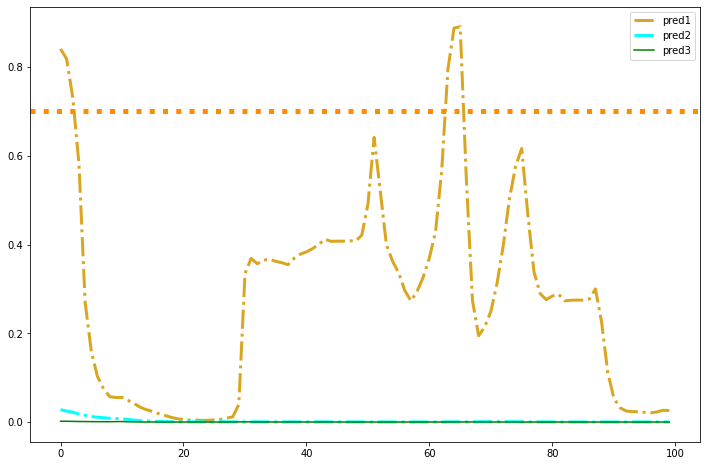

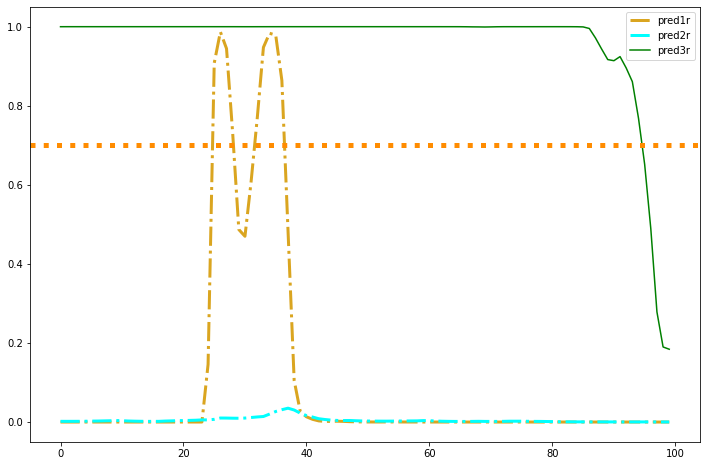

In [6]:
# 결과값이 없는 미래 예측을 위한 데이터셋 만들기
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df = df.dropna(axis=0)
df = df[-120:]

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:120]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[:-10]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[:-15]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)


df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/AMZN_dataset01.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/AMZN_dataset01.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

         date     pred1        pred1r  ...    pred3r  result01  result02
0    20181015  0.009702  7.255713e-14  ...  1.000000  0.018294        -1
1    20181016  0.011607  7.313861e-14  ...  1.000000  0.017103        -1
2    20181017  0.016793  8.981013e-14  ...  1.000000  0.014886        -1
3    20181018  0.029606  7.888360e-14  ...  1.000000  0.017354        -1
4    20181019  0.046846  7.182352e-14  ...  1.000000  0.020196        -1
..        ...       ...           ...  ...       ...       ...       ...
275  20191118  0.336523  5.384741e-18  ...  0.052000  0.024757         1
276  20191119  0.320891  5.373681e-18  ...  0.046730  0.022455         1
277  20191120  0.308491  5.110477e-18  ...  0.042420  0.021588         1
278  20191121  0.296709  4.940600e-18  ...  0.035462  0.021405         1
279  20191122  0.284617  4.502039e-18  ...  0.030884  0.020445         1

[280 rows x 9 columns]


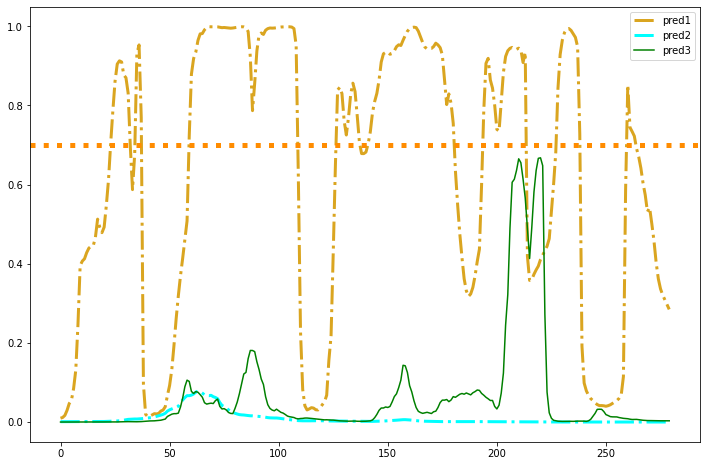

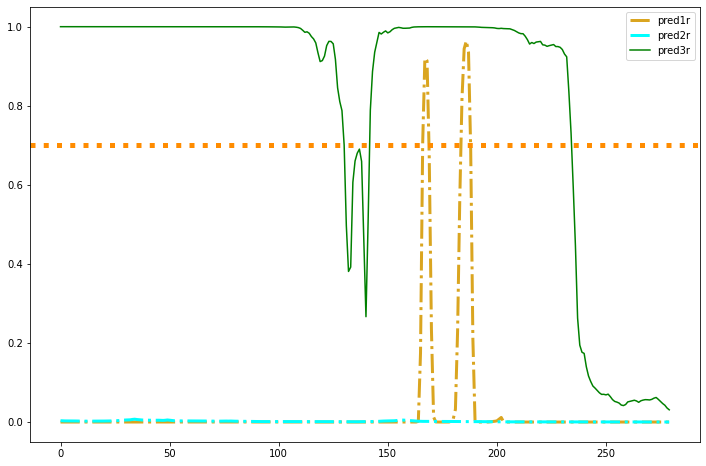

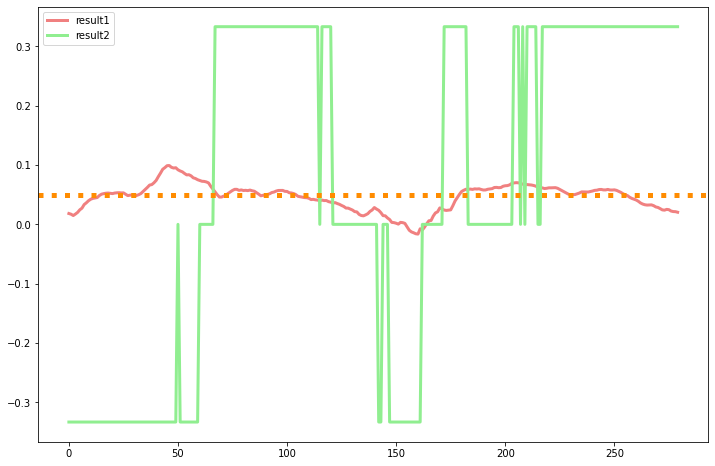

In [7]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df[-300:]

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if  row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:300]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[15:]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)
df2['result01'] = pd.Series(target)
df2['result02'] = pd.Series(target2)

df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/AAPL_dataset00.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/AAPL_dataset00.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result01'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)

plt.legend()
plt.show()

        date     pred1        pred1r     pred2    pred2r     pred3    pred3r
0   20200617  0.877712  2.673446e-14  0.088113  0.000799  0.005228  0.999998
1   20200618  0.828187  2.238888e-14  0.078523  0.000828  0.005154  0.999999
2   20200619  0.816777  2.758642e-14  0.071890  0.000854  0.004821  0.999999
3   20200622  0.831107  2.015065e-14  0.062640  0.000914  0.004257  0.999999
4   20200623  0.848340  1.634803e-14  0.055293  0.000962  0.004497  1.000000
..       ...       ...           ...       ...       ...       ...       ...
95  20201030  0.051507  2.215637e-15  0.000065  0.000631  0.000804  0.448457
96  20201102  0.051675  1.627966e-15  0.000071  0.000573  0.000928  0.386748
97  20201103  0.052373  6.031022e-16  0.000088  0.000481  0.002371  0.220865
98  20201104  0.054174  1.461684e-15  0.000102  0.000432  0.005338  0.149211
99  20201105  0.052840  2.747387e-16  0.000109  0.000367  0.007176  0.118676

[100 rows x 7 columns]


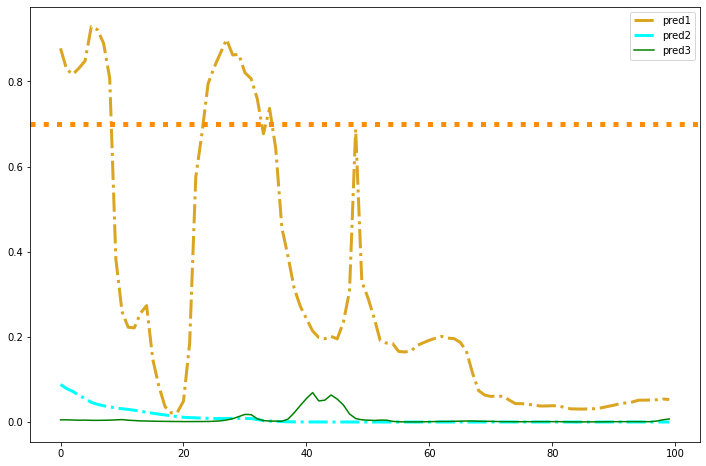

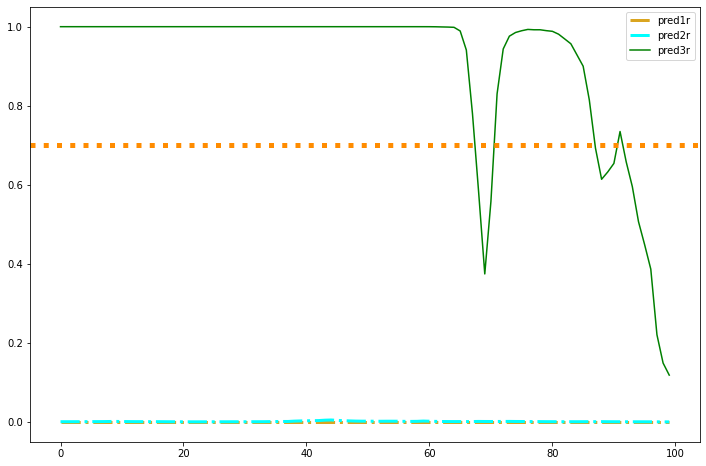

In [8]:
# 결과값이 없는 미래 예측을 위한 데이터셋 만들기
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df = df.dropna(axis=0)
df = df[-120:]

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:120]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[:-10]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[:-15]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)


df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/AAPL_dataset01.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/AAPL_dataset01.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

         date     pred1        pred1r  ...    pred3r  result01  result02
0    20181015  0.249588  5.126595e-04  ...  0.999999  0.064886         0
1    20181016  0.248543  2.066791e-04  ...  0.999999  0.062163         0
2    20181017  0.227691  5.253873e-05  ...  0.999999  0.060129         1
3    20181018  0.229157  6.705756e-06  ...  0.999999  0.060243         1
4    20181019  0.245578  5.196145e-07  ...  0.999999  0.064118         1
..        ...       ...           ...  ...       ...       ...       ...
275  20191118  0.135276  1.302071e-19  ...  0.030421  0.008443         1
276  20191119  0.110250  1.220060e-19  ...  0.028205  0.011790         1
277  20191120  0.087990  1.128638e-19  ...  0.026411  0.015383         1
278  20191121  0.072043  1.052050e-19  ...  0.023567  0.011266         1
279  20191122  0.055346  1.075295e-19  ...  0.022211  0.006883         1

[280 rows x 9 columns]


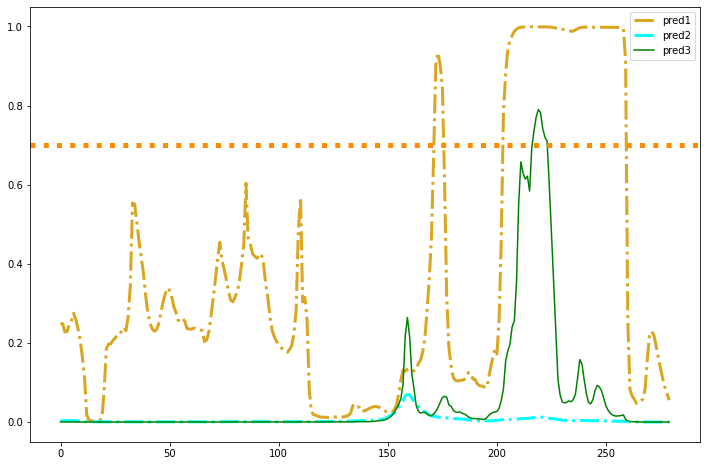

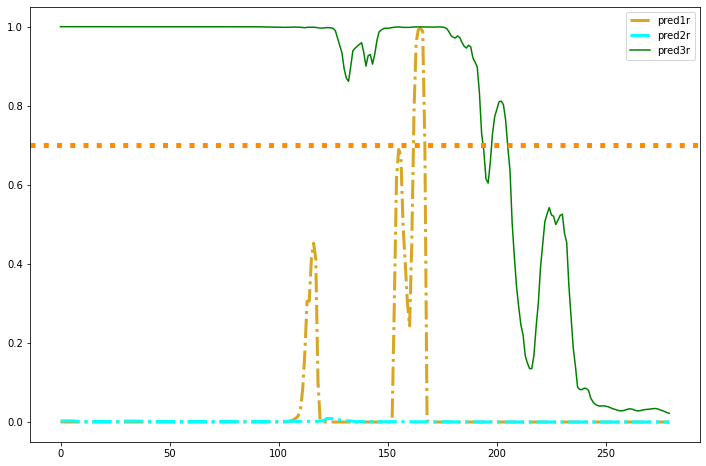

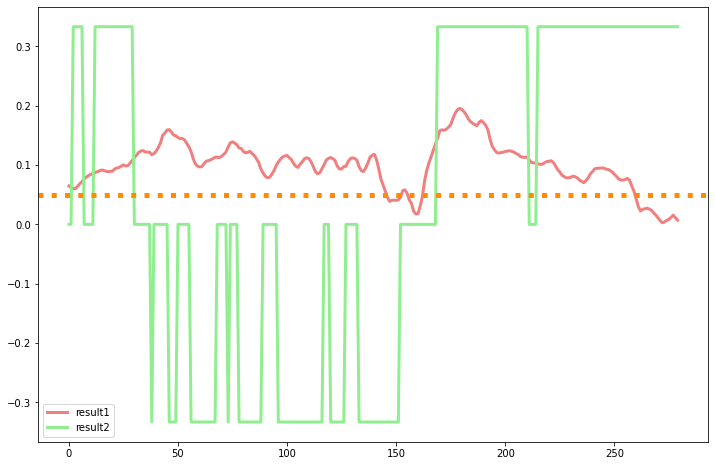

In [9]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df[-300:]

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']


df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if  row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:300]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[15:]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)
df2['result01'] = pd.Series(target)
df2['result02'] = pd.Series(target2)

df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/TSLA_dataset00.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/TSLA_dataset00.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result01'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)

plt.legend()
plt.show()

        date     pred1        pred1r     pred2    pred2r     pred3    pred3r
0   20200617  0.998776  1.331004e-10  0.044565  0.002454  0.000487  0.999997
1   20200618  0.998607  8.630004e-11  0.041396  0.002245  0.000523  0.999996
2   20200619  0.998235  4.151048e-11  0.038459  0.002102  0.000493  0.999996
3   20200622  0.998336  1.497403e-11  0.035296  0.002059  0.000523  0.999997
4   20200623  0.998324  6.115362e-12  0.033863  0.002111  0.000616  0.999997
..       ...       ...           ...       ...       ...       ...       ...
95  20201030  0.935692  3.317668e-20  0.000114  0.000483  0.000038  0.444333
96  20201102  0.946812  3.532959e-20  0.000120  0.000437  0.000042  0.493078
97  20201103  0.950538  3.862519e-20  0.000144  0.000425  0.000065  0.456066
98  20201104  0.951816  3.381284e-20  0.000160  0.000360  0.000079  0.373110
99  20201105  0.949993  3.654868e-20  0.000171  0.000332  0.000089  0.389425

[100 rows x 7 columns]


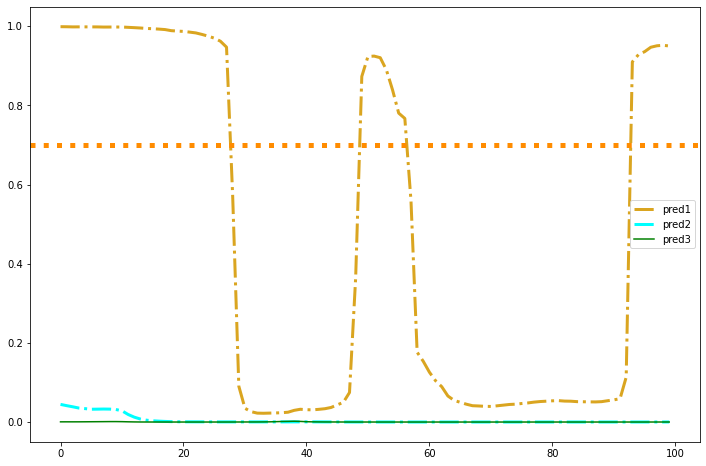

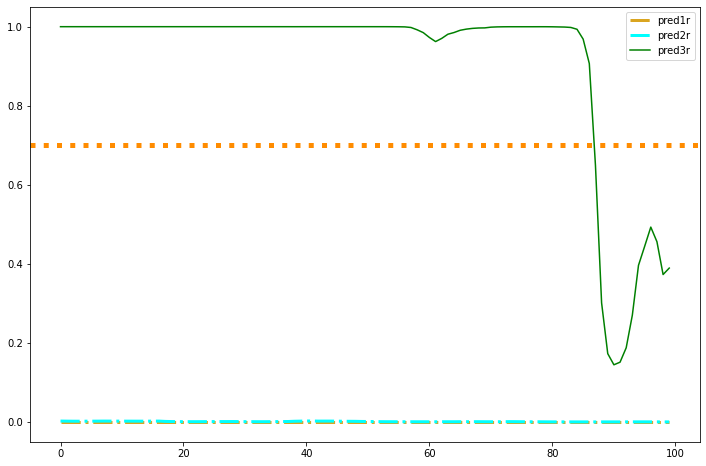

In [10]:
# 결과값이 없는 미래 예측을 위한 데이터셋 만들기
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df = df.dropna(axis=0)
df = df[-120:]

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:120]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[:-10]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[:-15]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)


df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/TSLA_dataset01.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/TSLA_dataset01.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

         date     pred1        pred1r  ...    pred3r  result01  result02
0    20181015  0.988270  4.391212e-14  ...  0.968810 -0.022893         0
1    20181016  0.988807  2.797828e-14  ...  0.964033 -0.024926         0
2    20181017  0.989441  1.884930e-14  ...  0.942587 -0.028658         0
3    20181018  0.989394  9.498709e-15  ...  0.881817 -0.030131         0
4    20181019  0.990018  2.053026e-15  ...  0.793783 -0.027315         0
..        ...       ...           ...  ...       ...       ...       ...
275  20191118  0.089237  5.713440e-14  ...  0.898132  0.017132         1
276  20191119  0.097445  2.891308e-14  ...  0.763456  0.016710         1
277  20191120  0.087170  1.493263e-14  ...  0.515327  0.018789         1
278  20191121  0.073251  6.442710e-15  ...  0.123407  0.021357         1
279  20191122  0.061480  1.549149e-15  ...  0.058069  0.021526         1

[280 rows x 9 columns]


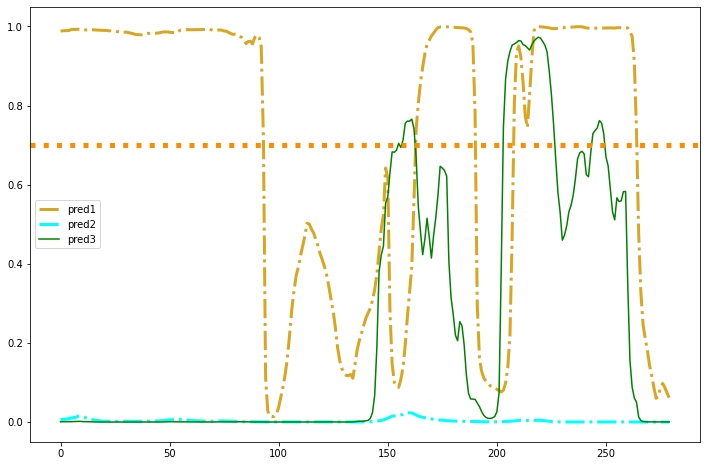

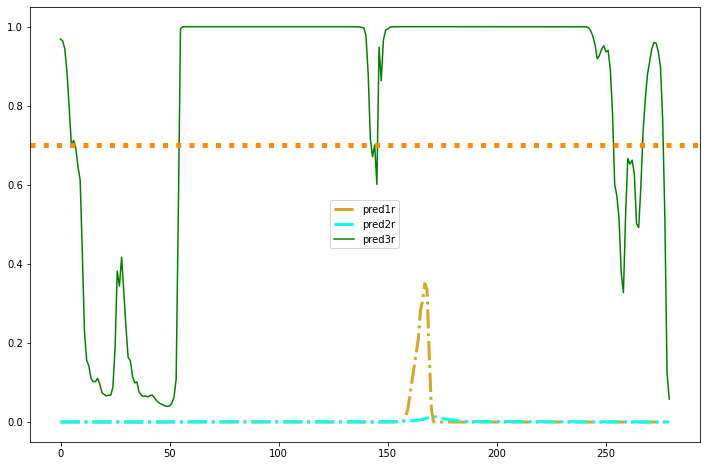

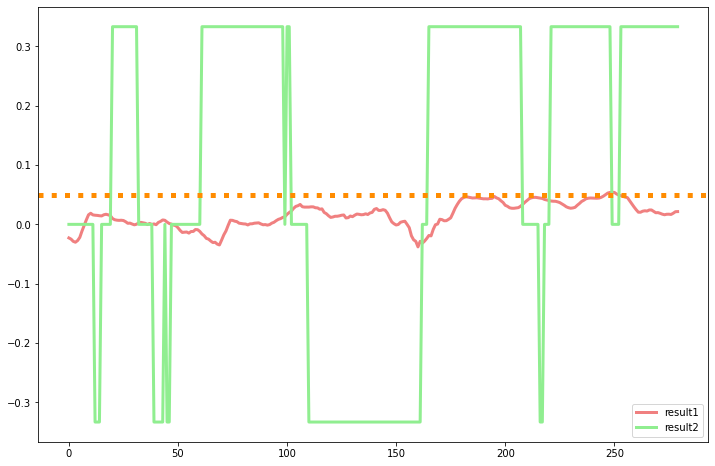

In [11]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df[-300:]

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if  row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:300]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[15:]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)
df2['result01'] = pd.Series(target)
df2['result02'] = pd.Series(target2)

df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/INTC_dataset00.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/INTC_dataset00.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result01'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)

plt.legend()
plt.show()

        date     pred1        pred1r     pred2    pred2r     pred3    pred3r
0   20200617  0.056352  5.081355e-11  0.000165  0.000260  0.000002  0.009002
1   20200618  0.061129  1.545172e-11  0.000170  0.000375  0.000003  0.008503
2   20200619  0.064284  5.295212e-12  0.000179  0.000440  0.000003  0.009499
3   20200622  0.068495  5.843344e-14  0.000183  0.000532  0.000003  0.012347
4   20200623  0.082096  2.658798e-16  0.000188  0.000669  0.000003  0.018765
..       ...       ...           ...       ...       ...       ...       ...
95  20201030  0.998375  3.429902e-05  0.003363  0.001149  0.880982  1.000000
96  20201102  0.998683  2.891004e-05  0.005083  0.001213  0.905407  1.000000
97  20201103  0.998864  2.195787e-05  0.007681  0.001286  0.922473  1.000000
98  20201104  0.999103  2.041262e-05  0.010771  0.001356  0.930593  1.000000
99  20201105  0.999315  1.760235e-05  0.014036  0.001321  0.925792  1.000000

[100 rows x 7 columns]


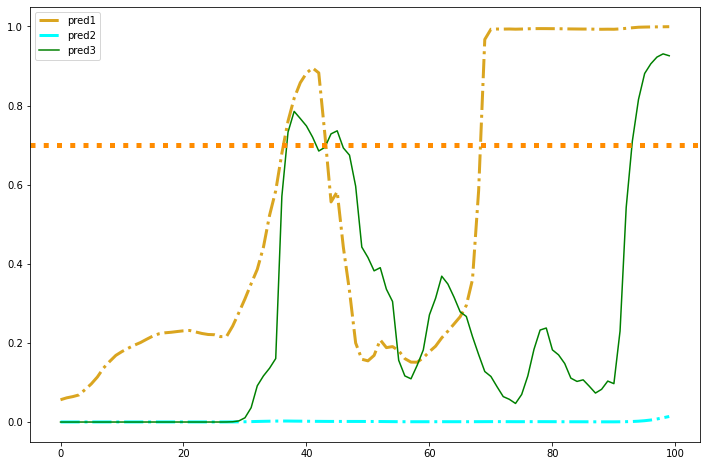

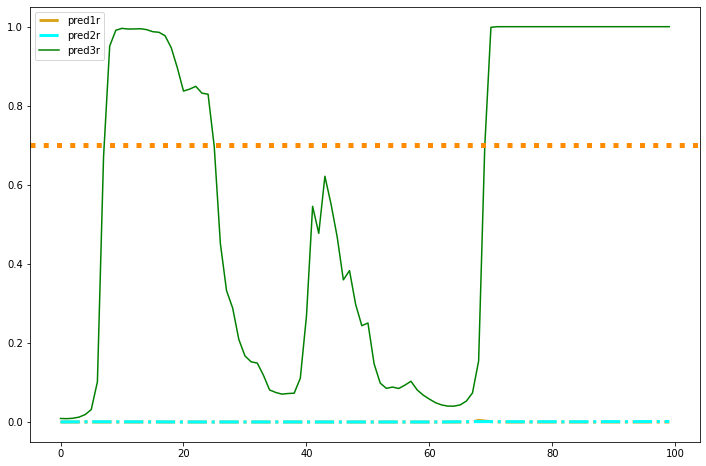

In [12]:
# 결과값이 없는 미래 예측을 위한 데이터셋 만들기
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df = df.dropna(axis=0)
df = df[-120:]

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:120]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[:-10]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[:-15]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)


df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/INTC_dataset01.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/INTC_dataset01.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

         date     pred1        pred1r  ...    pred3r  result01  result02
0    20181015  0.296317  3.249201e-12  ...  0.999999  0.031293        -1
1    20181016  0.316324  3.371116e-12  ...  0.999999  0.029030        -1
2    20181017  0.323238  3.221703e-12  ...  0.999999  0.025659        -1
3    20181018  0.322372  3.029195e-12  ...  0.999999  0.025864        -1
4    20181019  0.319244  2.871608e-12  ...  0.999999  0.028257        -1
..        ...       ...           ...  ...       ...       ...       ...
275  20191118  0.196724  1.178588e-17  ...  0.029424  0.001422         1
276  20191119  0.180418  1.423575e-17  ...  0.030292  0.001161         1
277  20191120  0.153779  1.446385e-17  ...  0.032178  0.000305         1
278  20191121  0.128822  1.633171e-17  ...  0.030767 -0.001497         1
279  20191122  0.105233  2.256010e-17  ...  0.029024 -0.002392         1

[280 rows x 9 columns]


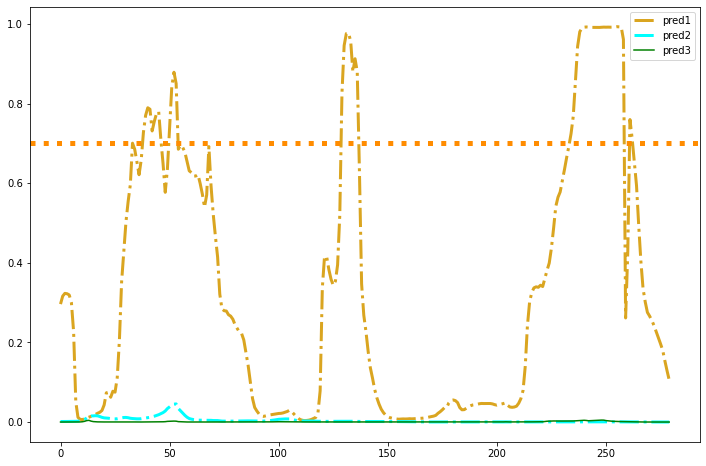

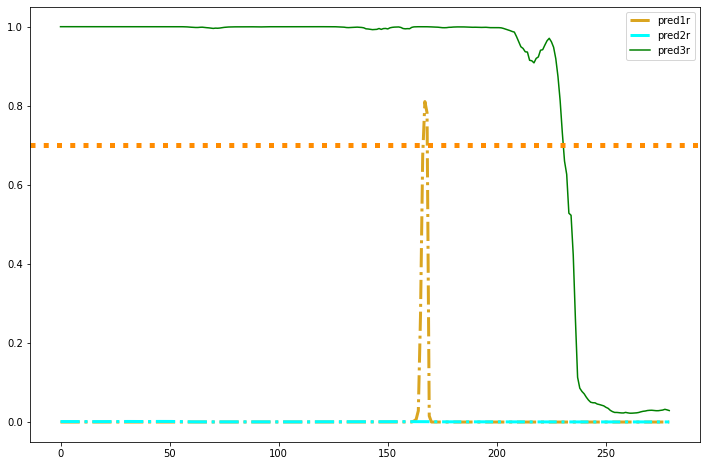

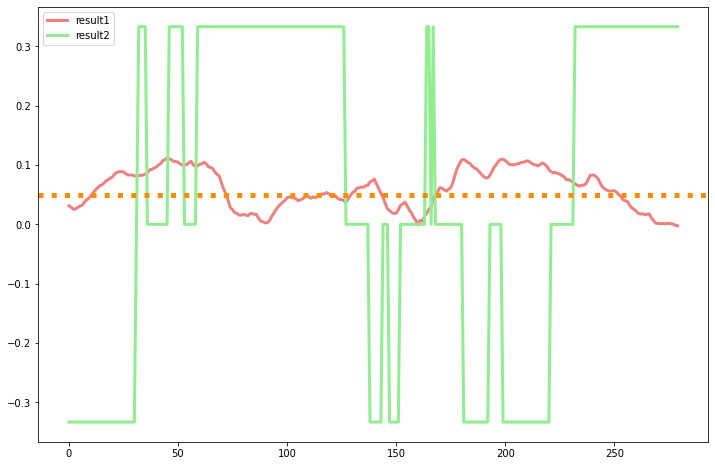

In [13]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df[-300:]

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df['return'].describe()

# 수익구간 정의
mark_01 = df['return'].quantile(q=.25, interpolation = 'nearest') # 고손실 수준
mark_02 = df['return'].quantile(q=.75, interpolation = 'nearest') # 고수익 수준
mark_03 = df['return'].quantile(q=.5, interpolation = 'nearest') # 정상 수익 수준

def scaler01(row) :
  if  row['return'] > 0  and row['return'] >= mark_03 : result = 1 # 정상 수익 구간 
  elif row['return'] <= mark_01: result = -1          # 초고 손실 구간
  else : result = 0                                  # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:300]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[15:]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)
df2['result01'] = pd.Series(target)
df2['result02'] = pd.Series(target2)

df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/AMD_dataset00.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/AMD_dataset00.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result01'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)

plt.legend()
plt.show()

        date     pred1        pred1r     pred2    pred2r     pred3    pred3r
0   20200617  0.982858  1.331004e-10  0.043724  0.002454  0.000658  0.999997
1   20200618  0.990665  8.630004e-11  0.042423  0.002245  0.000737  0.999996
2   20200619  0.996843  4.151048e-11  0.042161  0.002102  0.000752  0.999996
3   20200622  0.999541  1.497403e-11  0.040691  0.002059  0.000816  0.999997
4   20200623  0.999757  6.115362e-12  0.038995  0.002111  0.000922  0.999997
..       ...       ...           ...       ...       ...       ...       ...
95  20201030  0.049175  3.317668e-20  0.000080  0.000483  0.000008  0.444333
96  20201102  0.050687  3.532959e-20  0.000088  0.000437  0.000010  0.493078
97  20201103  0.053275  3.862519e-20  0.000101  0.000425  0.000023  0.456066
98  20201104  0.057197  3.381284e-20  0.000111  0.000360  0.000042  0.373110
99  20201105  0.057905  3.654868e-20  0.000110  0.000332  0.000044  0.389425

[100 rows x 7 columns]


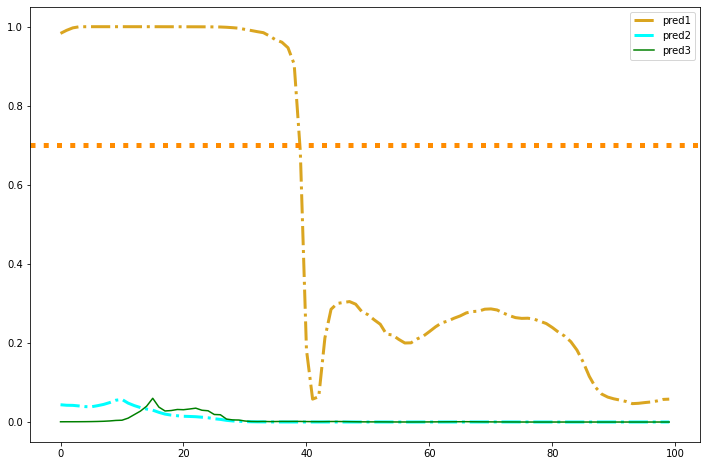

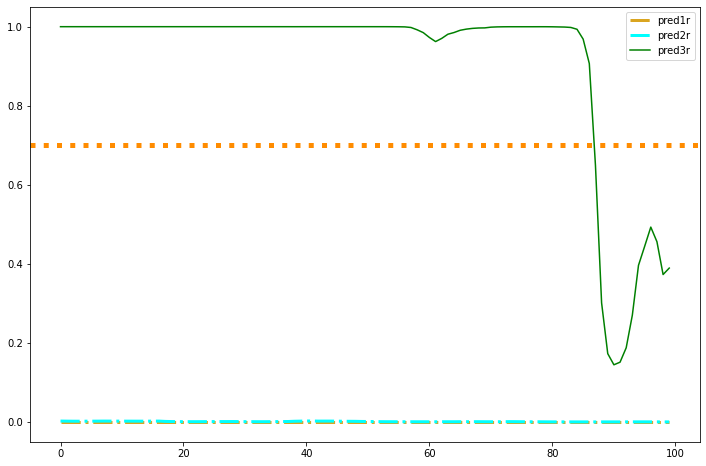

In [14]:
# 결과값이 없는 미래 예측을 위한 데이터셋 만들기
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df = df.dropna(axis=0)
df = df[-120:]

df2 = df.dropna(axis=0)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
date = df['date'].values[20:]

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")
model2_pred = model2.predict([X_2020,X_2020])[10:]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
from tensorflow.keras.models import load_model
model3 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model3_pred = model3.predict([X_2020,X_2020])[15:]

# 역방향 예측 불러오기
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df = df.dropna(axis=0)[:120]

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model1r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model1r_pred = model1r.predict([X_2020,X_2020,X_2020])

# model2 & model2r
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

model2r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")
model2r_pred = model2r.predict([X_2020,X_2020])[:-10]

# model3 & model3r
T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]
  
model3r = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model3r_pred = model3r.predict([X_2020,X_2020])[:-15]

pred_01 = np.zeros(len(model1_pred))
pred_01r = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))
pred_02r = np.zeros(len(model1_pred))
pred_03 = np.zeros(len(model1_pred))
pred_03r = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]
  pred_03[i] = model3_pred[i]
  pred_01r[i] = model1r_pred[i]
  pred_02r[i] = model2r_pred[i]
  pred_03r[i] = model3r_pred[i]

df2 = pd.DataFrame()
df2['date'] = pd.Series(date)
df2['pred1'] = pd.Series(pred_01)
df2['pred1r'] = pd.Series(pred_01r)
df2['pred2'] = pd.Series(pred_02)
df2['pred2r'] = pd.Series(pred_02r)
df2['pred3'] = pd.Series(pred_03)
df2['pred3r'] = pd.Series(pred_03r)


df2 = df2.dropna(axis=0)
df2.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)
df2

df2.to_csv("/content/gdrive/My Drive/AMD_dataset01.csv", index=False)

df = pd.read_csv("/content/gdrive/My Drive/AMD_dataset01.csv")
print(df)

plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3'], label = 'pred3' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['pred1r'],label ='pred1r' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2r'],label ='pred2r' , color = 'cyan', linestyle = '-.', linewidth = 3)
plt.plot(df['pred3r'], label = 'pred3r' , color = 'green')
plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.legend()
plt.show()